In [59]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D, core
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
import tensorflow as tf
from keras.applications import Xception
from keras.utils import multi_gpu_model
import os
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Cropping2D, Multiply, subtract
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from skimage.transform import rotate
from keras.preprocessing.image import ImageDataGenerator  #new
from keras import backend as K
from sklearn.feature_extraction import image
import h5py
%matplotlib notebook
#import cv2 #use conda install -c https://conda.binstar.org/menpo opencv3
import imgaug as ia  #see https://imgaug.readthedocs.io/en/latest/source/installation.html
from imgaug import augmenters as iaa


In [80]:
## DEFINE THE U NET MODEL ###
#######################################################################################

def pixelwise_crossentropy(y_true,y_pred):
    print(y_true.shape)
    class_weights = [1,2]
    y_pred = tf.clip_by_value(y_pred, 10e-8, 1. - 10e-8) #this clip by value command clips the tensor between some min and max values, which are some small amount away from 0 and 1, respectively
    return - tf.reduce_sum(tf.multiply(y_true * tf.log(y_pred),class_weights)) #note that the tf.multiply here is broadcasted multiplication

def pixelwise_crossentropy2(y_true,y_pred):
    epsilon = tf.convert_to_tensor(10e-4, y_pred.dtype.base_dtype)
    foreground_weight = 0.7#1-tf.reduce_sum(y_true)/212
    background_weight = 0.3#1-foreground_weight
    class_weights = [background_weight,foreground_weight]
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon) #this clip by value command clips the tensor between some min and max values, which are some small amount away from 0 and 1, respectively
    return -tf.reduce_sum(tf.multiply(y_true * tf.log(y_pred),class_weights)) 

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))


## Original Unet model
def get_unet(large_tile_size):
    inputs = Input((large_tile_size, large_tile_size, 3))
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='valid')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='valid')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='valid')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='valid')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='valid')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='valid')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='valid')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='valid')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='valid')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='valid')(conv5)
    
    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='valid')(conv5), Cropping2D(cropping=((4,4),(4,4)))(conv4)])
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='valid')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='valid')(conv6)
    
    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='valid')(conv6), Cropping2D(cropping=((16,16),(16,16)))(conv3)])
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='valid')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='valid')(conv7)
    
    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='valid')(conv7), Cropping2D(cropping=((40,40),(40,40)))(conv2)])
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='valid')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='valid')(conv8)
    
    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='valid')(conv8), Cropping2D(cropping=((88,88),(88,88)))(conv1)])
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='valid')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='valid')(conv9)
    
    conv10 = Conv2D(1, (1, 1),activation = 'softmax')(conv9) #the output is 388x388x12 containing unscaled log probabilities     print(conv10)
    model = Model(inputs=[inputs], outputs=[conv10])
    
    return model





def quadrant(OG_image):  
    original_size = OG_image.shape
#     print("original size and half of original size is ",original_size,int(original_size[0]/2))
    quad1=OG_image[0 : int(original_size[0]/2), 0 : int(original_size[1]/2), : ]
    quad3=OG_image[int(original_size[0]/2) : original_size[0], 0 : int(original_size[1]/2),: ]
    quad2=OG_image[0 : int(original_size[0]/2), int(original_size[1]/2) : original_size[1],: ]
    quad4=OG_image[int(original_size[0]/2) : original_size[0] , int(original_size[1]/2) : original_size[1],: ] 
    return quad1,quad2,quad3,quad4 


def symmetricpadding(quadrant,final_panel_size):
    quadrant_size = quadrant.shape
    #print(quadrant_size)
    a= int((final_panel_size - quadrant_size[0])/2)
    b= int((final_panel_size - quadrant_size[1])/2)
    paddings = [ [a, b], [a, b], [0,0] ]
    final_image= np.pad(quadrant, paddings,"constant",constant_values=(0,0)) # "REFLECT")
    return final_image

def zeropadding(quadrant,final_panel_size):#it is actuallly zeropadding now
    quadrant_size = quadrant.shape
    #print(quadrant_size)
    a= int((final_panel_size - quadrant_size[0])/2)
    b= int((final_panel_size - quadrant_size[1])/2)
    paddings = [ [a, b], [a, b], [0,0] ]
    final_image= np.pad(quadrant, paddings,"constant",constant_values=(0,0)) # "REFLECT")
    return final_image



def crop_image(final_panel_size,OG_image):
# Only consider the inside of the images for purposes of analysis
    half_panel = int(final_panel_size/2)
    original_size = OG_image.shape
    first_dim_start = int(original_size[0]/2)
    second_dim_start = int(original_size[1]/2)
    new_image = OG_image[first_dim_start-half_panel:first_dim_start+half_panel,
                         second_dim_start-half_panel:second_dim_start+half_panel,:]
    return new_image.reshape([final_panel_size,final_panel_size,3])

def crop_truth(final_panel_size,OG_image):
    half_panel = int(final_panel_size/2)
    original_size = OG_image.shape
    first_dim_start = int(original_size[0]/2)
    second_dim_start = int(original_size[1]/2)
    new_truth = OG_image[first_dim_start-half_panel:first_dim_start+half_panel,
                         second_dim_start-half_panel:second_dim_start+half_panel]
    return new_truth.reshape([final_panel_size, final_panel_size, 1])

def rgb2gray(rgb):
    new = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    return new.reshape([rgb.shape[0],rgb.shape[1],1])

def get_rgb_meanSD(rgb):
    mean = [float(np.mean(rgb[...,0])),float(np.mean(rgb[...,1])),float(np.mean(rgb[...,2]))]
    std = [float(np.std(rgb[...,0])),float(np.std(rgb[...,1])),float(np.std(rgb[...,2]))]
    return mean,std

def get_rgb_max_min(rgb):
    rgb_max = [float(np.max(rgb[...,0])),float(np.max(rgb[...,1])),float(np.max(rgb[...,2]))]
    rgb_min = [float(np.min(rgb[...,0])),float(np.min(rgb[...,1])),float(np.min(rgb[...,2]))]
    return rgb_max,rgb_min

def norm_rgb(rgb,mu,sigma):
    rnorm = (rgb[...,0]-mu[0])/(sigma[0])
    gnorm = (rgb[...,1]-mu[1])/(sigma[1])
    bnorm = (rgb[...,2]-mu[2])/(sigma[2])
    new_image = np.stack((rnorm,gnorm,bnorm),axis =2)
    #print(rnorm,gnorm,bnorm)
    return new_image#.reshape(rgb.shape[0],rgb.shape[1],3)
    
def maxmin_rgb(rgb,rgbmax,rgbmin):
    rnorm = (rgbmax[0] - rgb[...,0])/(rgbmax[0] - rgbmin[0])
    gnorm = (rgbmax[1] - rgb[...,1])/(rgbmax[1] - rgbmin[1])
    bnorm = (rgbmax[2] - rgb[...,2])/(rgbmax[2] - rgbmin[2])
    new_image = np.stack((rnorm,gnorm,bnorm),axis =2)
    #print(rnorm,gnorm,bnorm)
    return new_image#.reshape(rgb.shape[0],rgb.shape[1],3)


def precision(y_true, y_pred):
    """Precision metric.
     Only computes a batch-wise average of precision.
     Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


###############################################################################################


In [81]:
u_net_test = get_unet(556+16*10)
u_net_test.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 716, 716, 3)  0                                            
__________________________________________________________________________________________________
conv2d_220 (Conv2D)             (None, 714, 714, 64) 1792        input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_221 (Conv2D)             (None, 712, 712, 64) 36928       conv2d_220[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_49 (MaxPooling2D) (None, 356, 356, 64) 0           conv2d_221[0][0]                 
__________________________________________________________________________________________________
conv2d_222

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Lib

(20, 532, 532, 3)
(20, 532, 532, 1)


<IPython.core.display.Javascript object>


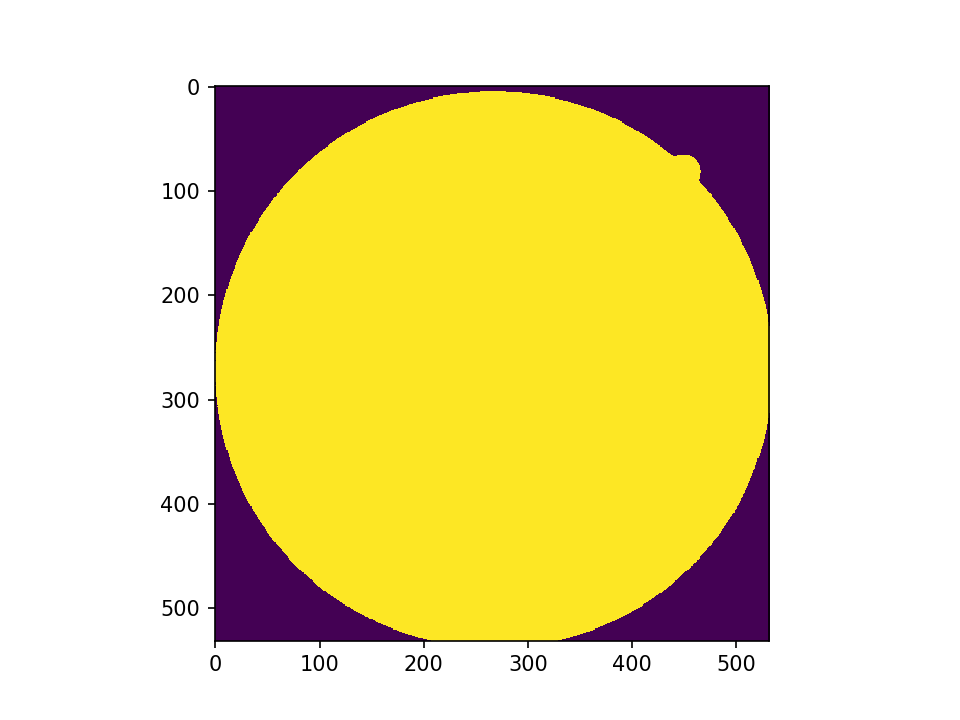

In [62]:

# Create a vector of truths and images
# Big tile size is 552 x 552. We want the quadrants, which are 276x276. This means that the starting panel size is 364
input_size = 716 #364
image_size = 532 #276
panel_size = 532


## Create the files
## Create the files
train_images = []
test_images  = []
train_truth  = []
test_truth   = []
train_masks = []
test_masks = []



for i in range(20):
    name_train        = "DRIVE/training/images/" + str(21 + i) + "_training.tif"
    name_train_truth  = "DRIVE/training/1st_manual/" + str(21 + i) + "_manual1.gif"
    name_test         = "DRIVE/test/images/" + str(1+i) + "_test.tif"
    name_test_truth   = "DRIVE/test/1st_manual/" + str(1+i) + "_manual1.gif"
    name_train_mask   = "DRIVE/training/mask/" + str(21 + i) + "_training_mask.gif"
    name_test_mask    = "DRIVE/test/mask/" + str(1+i) + "_test_mask.gif"
    
    
    
    train_images.append(crop_image(panel_size, misc.imread(name_train)))
    test_images.append(crop_image(panel_size, misc.imread(name_test)))
    
    train_truth.append(crop_truth(panel_size, misc.imread(name_train_truth))/255)
    test_truth.append(crop_truth(panel_size, misc.imread(name_test_truth))/255)
    
    train_masks.append(crop_truth(panel_size, misc.imread(name_train_mask))/255)
    test_masks.append(crop_truth(panel_size, misc.imread(name_test_mask))/255)
    

train_images = np.stack(train_images)
train_truth = np.stack(train_truth)
train_masks = np.stack(train_masks)
test_images = np.stack(test_images)
test_truth = np.stack(test_truth)
test_masks = np.stack(test_masks)

print(train_images.shape)
print(train_truth.shape)
plt.figure()
plt.imshow(test_masks[0,...].reshape(panel_size,panel_size))
plt.show()


In [63]:
##### USE THIS FOR THE WHOLE IMAGE



pad_size = input_size
num_rotations = 10
num_images = 20
final_images = np.zeros([4*num_images*num_rotations,input_size,input_size,3]).astype(int)
final_truth  = np.zeros([4*num_images*num_rotations,image_size,image_size,1]).astype(int)
final_masks  = np.zeros([4*num_images*num_rotations,input_size,input_size,1]).astype(int)
train = [zeropadding(train_images[_], pad_size) for _ in range(20)]
mask  = [zeropadding(train_masks[_], pad_size) for _ in range(20)]
# plt.imshow(train[0])
# plt.show()
train_image_padding = np.stack(train, axis=0)
train_mask_padding  = np.stack(mask,  axis=0)
# train_image_padding *= train_mask_padding
outeri = 0
for rot_number in range(num_rotations):
    ia.seed(np.random.randint(0,100))
    rotation = np.random.randint(1,271)
    shearing = np.random.randint(1,21)
    ia.seed(np.random.randint(100))
    seq = iaa.Sequential([iaa.Affine(rotate=rotation,shear=shearing)],random_order=False)
    images_aug_truth = seq.augment_images(train_truth)
    images_aug_mask  = seq.augment_images(train_mask_padding)
    print(np.max(images_aug_mask))
    images_aug       = seq.augment_images(train_image_padding)
    
    # Normalize
    stack_images_train = np.concatenate(np.concatenate(images_aug))
#     mu_train,sigma_train = get_rgb_meanSD(stack_images_train)
    max_train,min_train = get_rgb_max_min(stack_images_train)
#     print(mu_train,sigma_train)

    
    for im in range(num_images):
        final_truth[outeri,...]  = images_aug_truth[im,...]
        final_masks[outeri,...]  = images_aug_mask[im,...]
#         final_images[outeri,...] = maxmin_rgb(images_aug[im,...],max_train,min_train)*final_masks[outeri,...]
        final_images[outeri,...] = images_aug[im,...]*final_masks[outeri,...]

        outeri += 1

print(outeri)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
200


In [64]:
#Kevin suggestions 1: Ensure that the two channel masks are correct (i.e. 0,1 output)
print(np.max(final_masks),np.min(final_masks))


1 0


<IPython.core.display.Javascript object>


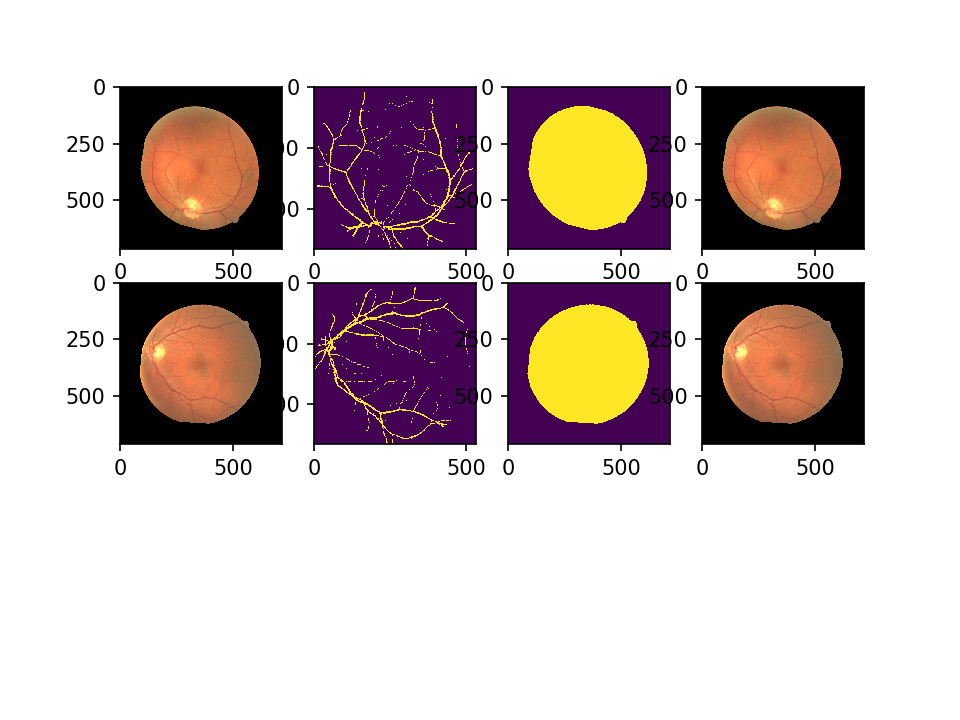

In [65]:
#Kevin suggestions 2/3: Make sure the tilings are correct and image augmentation matches the truth augmentions
plt.figure()
for i in range(1,3):
    rand_id = np.random.randint(0,200)
    plt.subplot(3,4,4*i - 3)
    plt.imshow(final_images[rand_id,...])
    plt.subplot(3,4,4*i-2)
    plt.imshow(final_truth[rand_id,...].reshape(image_size,image_size))
    plt.subplot(3,4,4*i-1)
    plt.imshow(final_masks[rand_id,...].reshape(input_size,input_size))
    plt.subplot(3,4,4*i)
    plt.imshow(final_masks[rand_id,...]*final_images[rand_id,...])
plt.show()

In [73]:
# Run original u-net model with original pixel-wise crossentropy loss, and Adam optimizer.
unet_model = get_unet(input_size)
unet_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 716, 716, 3)  0                                            
__________________________________________________________________________________________________
conv2d_201 (Conv2D)             (None, 714, 714, 64) 1792        input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_202 (Conv2D)             (None, 712, 712, 64) 36928       conv2d_201[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_45 (MaxPooling2D) (None, 356, 356, 64) 0           conv2d_202[0][0]                 
__________________________________________________________________________________________________
conv2d_203

In [ ]:

unet_model.compile(optimizer = keras.optimizers.Adam(),
                   loss = pixelwise_crossentropy,
                   metrics = ['accuracy',precision])
# print(keras.utils.to_categorical(final_truth[0:50,51,50,:]))
#fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)
unet_model.fit(final_images, final_truth,
                  batch_size = 1,
                  epochs=10,
                  verbose=1,
              validation_split = 0.2)

(?, ?, ?, ?)
Train on 640 samples, validate on 160 samples
Epoch 1/10
103/640 [===>..........................] - ETA: 2:01:46 - loss: 0.0021 - acc: 0.0207 - precision: 0.0207

[[[[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  ...

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]]]


<IPython.core.display.Javascript object>


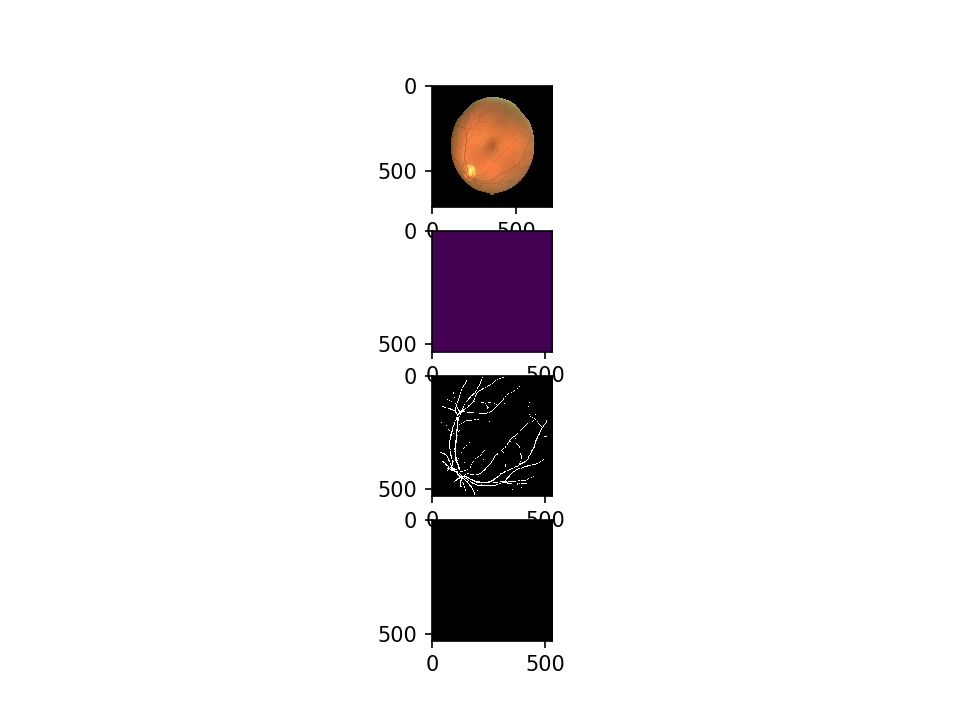

In [77]:
pred1 = unet_model.predict(final_images[111,...].reshape(1,input_size,input_size,3))
print(pred1)

figpred = plt.figure()
plt.subplot(4,1,1)
plt.imshow(final_images[111,...])
plt.subplot(4,1,2)
plt.imshow(pred1[...,0].reshape(image_size,image_size))
plt.subplot(4,1,3)
plt.imshow(final_truth[111,...].reshape(image_size,image_size),cmap='gray')

temp = np.greater_equal(pred1[...],0.1)
plt.subplot(4,1,4)
plt.imshow(temp.reshape(image_size,image_size),cmap='gray')

In [86]:

# datagen = ImageDataGenerator(rotation_range=90)   #rotation
# Configure batch size and retrieve one batch of images
# HOW TO SAVE FILES????
inneri = 1
# seed = np.seed()
# for X_batch in datagen.flow(final_truth, final_images, batch_size=4):
#     print(inneri)
#     inneri+=1
#     for i in range(0, 1):
#         data = X_batch
#         image = data[0]
#         truth = data[1]
#         print(image.shape)
#         print(truth.shape)
#         fig1 = plt.figure()
#         for j in range(4):
#             print(image[j,...].shape)
#             plt.subplot(2,2,j+1)
#             plt.imshow(image[j,...])#.reshape(input_size,input_size,3))
#     plt.show()
#     fig2 = plt.figure()
#     for j in range(4):
#             plt.subplot(2,2,j+1)
#             plt.imshow(truth[j,...])#.reshape(image_size,image_size,3))
# #             plt.subplot(2,2,j+1)
# #             plt.imshow((truth[j,...]).reshape(image_size,image_size,3))
#     plt.show()
#     break
    
    
# # Testing by Mitchel (12/4/18)
num_batches = 80
angles = np.round(np.random.rand(num_batches)*360)
big_image_data = np.zeros([num_batches*4,364,364,3]).astype(int)
big_truth_data = np.zeros([num_batches*4,276,276,1]).astype(int)
print(angles)
# fig3 = plt.figure()
for quad in range(20):
    for i in range(num_batches):
        # Generate some random rotation
        #image = final_images[quad,...]
        image = train_images[quad,...]
        image = rotate(image,angles[i],preserve_range='True').astype(int)
        big_image_data[num_batches*quad + i,...] = image
#         plt.subplot(num_batches,4,quad*num_batches+i+1)
#         plt.imshow(big_image_data[num_batches*quad + i,...])
      
    
    
    
fig4 = plt.figure()
for quad in range(20):
    for j in range(num_batches):
        truth = rotate(final_truth[quad,...],angles[j],preserve_range='True')
        big_truth_data[num_batches*quad + i,...] = truth
#         plt.subplot(num_batches,4,quad*num_batches+j+1)
#         plt.imshow(big_truth_data[num_batches*quad + i,...]*[255,255,255])

# plt.show()
print(big_image_data.shape, big_truth_data.shape)

[  34.  175.  238.  190.   81.   33.  353.  217.  221.  111.  102.  309.
  299.   17.   21.  308.   21.  231.  290.   44.   19.  233.   18.   62.
  318.  142.   91.  254.  188.   15.  212.   54.  118.  359.  261.  205.
  236.  328.  244.  235.  257.   85.  329.  167.   53.  313.   34.  247.
  224.  109.  205.   44.  261.  234.  171.  174.  296.  199.  336.  156.
  306.  184.  293.   90.  115.  250.  182.  246.  325.  164.  214.   34.
   17.  139.   92.  292.  313.  132.  249.  263.]


IndexError: index 320 is out of bounds for axis 0 with size 320

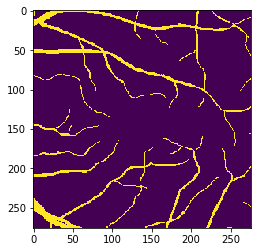

In [82]:
plt.figure()
plt.imshow(train_truth[0].reshape(276,276))
plt.show()

In [23]:

# a = dice_coef(big_truth_data[0,...],big_truth_data[1,...])
# print(a.value_index)
# fig = plt.figure()
# plt.subplot(211)
# plt.imshow(big_image_data[0,...])
# plt.subplot(212)
# plt.imshow(big_truth_data[0,...]*[255,255,255])
# plt.show()

In [81]:
unet_model.fit(train_images[0:20,...], train_truth[0:80,...],
                  batch_size = 1,
                  epochs=1,
                  verbose=1)

Epoch 1/1
20/20 [==============================] - 84s 4s/step - loss: 2206.5995 - acc: 0.0000e+00 - precision: 0.1135


In [25]:
print(unet_model.get_weights)

<bound method Model.get_weights of <keras.engine.training.Model object at 0x1310c71d0>>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 116, 116, 1)
[[[ 1.]
  [ 1.]
  [ 1.]
  ..., 
  [ 1.]
  [ 1.]
  [ 1.]]

 [[ 1.]
  [ 1.]
  [ 1.]
  ..., 
  [ 1.]
  [ 1.]
  [ 1.]]

 [[ 1.]
  [ 1.]
  [ 1.]
  ..., 
  [ 1.]
  [ 1.]
  [ 1.]]

 ..., 
 [[ 1.]
  [ 1.]
  [ 1.]
  ..., 
  [ 1.]
  [ 1.]
  [ 1.]]

 [[ 1.]
  [ 1.]
  [ 1.]
  ..., 
  [ 1.]
  [ 1.]
  [ 1.]]

 [[ 1.]
  [ 1.]
  [ 1.]
  ..., 
  [ 1.]
  [ 1.]
  [ 1.]]]


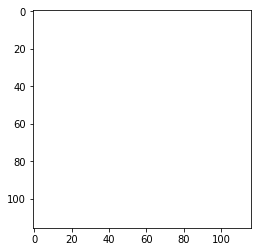

In [28]:
pred1 = unet_model.predict(big_image_data[1,...].reshape([1,input_size,input_size,3]))
print(pred1.shape)
fig_pred = plt.figure()
print(max(pred1))
plt.imshow(pred1[0,...]*[255,255,255])

(116, 116)
[[[ 1.]
  [ 1.]
  [ 1.]
  ..., 
  [ 1.]
  [ 1.]
  [ 1.]]

 [[ 1.]
  [ 1.]
  [ 1.]
  ..., 
  [ 1.]
  [ 1.]
  [ 1.]]

 [[ 1.]
  [ 1.]
  [ 1.]
  ..., 
  [ 1.]
  [ 1.]
  [ 1.]]

 ..., 
 [[ 1.]
  [ 1.]
  [ 1.]
  ..., 
  [ 1.]
  [ 1.]
  [ 1.]]

 [[ 1.]
  [ 1.]
  [ 1.]
  ..., 
  [ 1.]
  [ 1.]
  [ 1.]]

 [[ 1.]
  [ 1.]
  [ 1.]
  ..., 
  [ 1.]
  [ 1.]
  [ 1.]]]


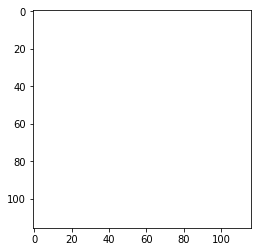

In [29]:
# raw = np.random.randint(10, size=(6,6))
# # apply some logic operatioin to the data
# O = (raw >= 5) * 1   # get either 0 or 1 in the array
# print(O.shape)

print(pred1[0,:,:,0].shape)
print(min(pred1))
plt.imshow(pred1[0,:,:,0],cmap='Greys')
plt.show()

In [43]:
## Code from the retinal paper
# def get_unet(n_ch,patch_height,patch_width):
#     inputs = Input(shape=(n_ch,patch_height,patch_width))
#     conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(inputs)
#     conv1 = Dropout(0.2)(conv1)
#     conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv1)
#     pool1 = MaxPooling2D((2, 2))(conv1)
#     #
#     conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool1)
#     conv2 = Dropout(0.2)(conv2)
#     conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv2)
#     pool2 = MaxPooling2D((2, 2))(conv2)
#     #
#     conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool2)
#     conv3 = Dropout(0.2)(conv3)
#     conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv3)

#     up1 = UpSampling2D(size=(2, 2))(conv3)
#     up1 = concatenate([conv2,up1],axis=1)
#     conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up1)
#     conv4 = Dropout(0.2)(conv4)
#     conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv4)
#     #
#     up2 = UpSampling2D(size=(2, 2))(conv4)
#     up2 = concatenate([conv1,up2], axis=1)
#     conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(up2)
#     conv5 = Dropout(0.2)(conv5)
#     conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv5)
#     #
#     conv6 = Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_first')(conv5)
#     conv6 = core.Reshape((2,patch_height*patch_width))(conv6)
#     conv6 = core.Permute((2,1))(conv6)
#     ############
#     conv7 = core.Activation('softmax')(conv6)

#     model = Model(inputs=inputs, outputs=conv7)

#     # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
# #     model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])

#     return model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 1, 540, 540)  0                                            
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 32, 540, 540) 320         input_10[0][0]                   
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 32, 540, 540) 0           conv2d_135[0][0]                 
__________________________________________________________________________________________________
conv2d_136 (Conv2D)             (None, 32, 540, 540) 9248        dropout_19[0][0]                 
__________________________________________________________________________________________________
max_poolin

(232, 232, 1)
(45, 45)


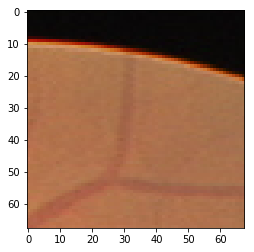

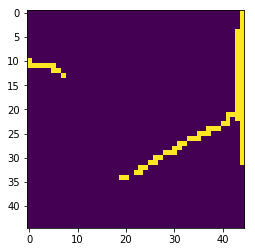

In [15]:
a = train_images[0]
b = train_truth[0]
print(b.shape)
patches = image.extract_patches_2d(a, (68, 68),max_patches = 300,random_state = 100)
patch_truth = image.extract_patches_2d(b, (45, 45),max_patches = 300,random_state = 100)
print(patch_truth[0].shape)
plt.figure()
plt.imshow(patches[0])
plt.show()
plt.imshow(patch_truth[0])
plt.show()